# Differentiability  

The core idea behind Rendervous is to construct renderers using differentiable building blocks that can be composed seamlessly. For example, consider a volume where:  
- Densities are represented as an implicit neural representation,  
- The scattering albedo is defined using a grid, and  
- Emission is modeled with a spherical harmonics (SH) field.  

A renderer, represented as another map, can evaluate these components by integrating along a ray or a path. Gradients can then be backpropagated to the parameters defining these fields, enabling end-to-end optimization.

In [1]:
import rendervous as rdv
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def view_map(x, y):
    xs = x[...,0]
    ys = x[...,1]
    zs = y[...,0]
    plt.scatter(xs.cpu(), ys.cpu(), c=zs.cpu(), vmin=-.4, vmax=0.4)
    plt.show()

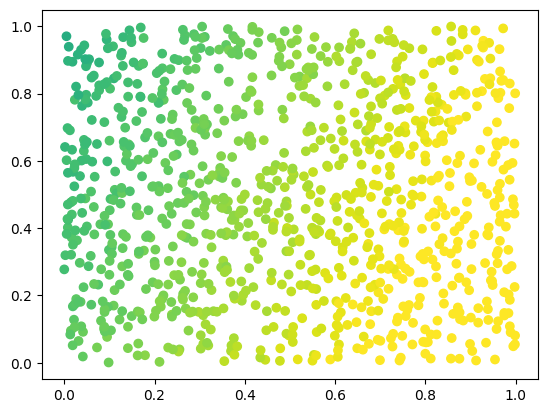

In [3]:
SAMPLES = 1000
zA = torch.tensor([[0.3, -0.1]], device=rdv.device())
zB = torch.tensor([0.2], device=rdv.device())
x = torch.rand(SAMPLES, 2, device=rdv.device()) # map input (not important in the case of a constant field)
y = torch.randn(SAMPLES, 1, device=rdv.device())*0.01 + x @ zA.T + zB
view_map(x, y)

## A constant regression example

Next example will define a constant regression by means of a parameterized constant map.

Loss: 0.00878781545907259: 100%|██████████| 1000/1000 [00:07<00:00, 126.09it/s]


Parameter containing:
tensor([0.2976], device='cuda:0', requires_grad=True)
tensor([0.2977], device='cuda:0')


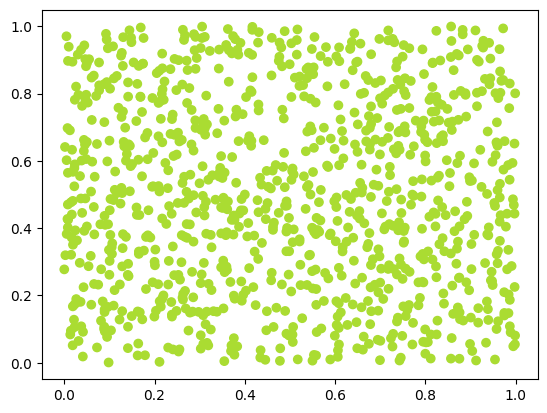

In [4]:
p = torch.nn.Parameter(torch.tensor([0.0], device=rdv.device()))

m = rdv.const[p]

optimizer = torch.optim.Adam([p], lr=0.001)

steps_iterator = tqdm(range(1000))
for s in steps_iterator:
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(m(x), y)
    loss.backward()
    steps_iterator.set_description_str(f"Loss: {loss.item()}")
    optimizer.step()

print(p)
print(y.mean(dim=0))

with torch.no_grad():
    view_map(x, m(x))

## Linear regression

Loss: 0.00010830316023202613: 100%|██████████| 5000/5000 [00:22<00:00, 223.00it/s]


Parameter containing:
tensor([[ 0.2988, -0.1010]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.2013], device='cuda:0', requires_grad=True)


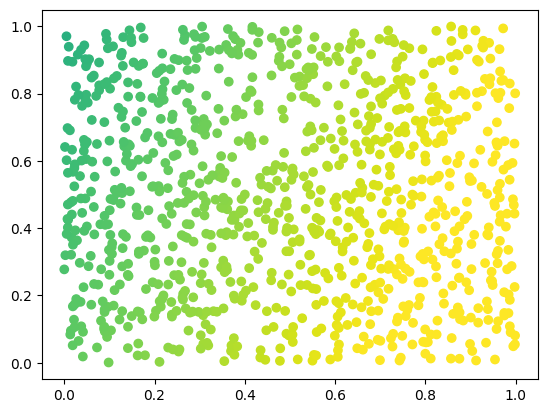

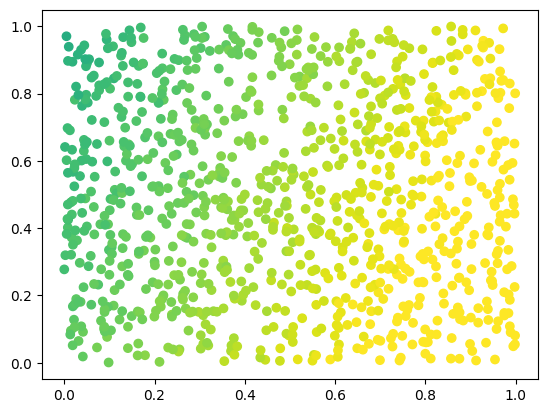

In [5]:
A = torch.nn.Parameter(torch.randn(1, 2, device=rdv.device()))
B = torch.nn.Parameter(torch.zeros(1, device=rdv.device()))

m = A @ rdv.X + rdv.const[B]

optimizer = torch.optim.NAdam([A, B], lr=0.002)

steps_iterator = tqdm(range(5000))
for s in steps_iterator:
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(m(x), y)
    loss.backward()
    steps_iterator.set_description_str(f"Loss: {loss.item()}")
    optimizer.step()

print(A)
print(B)

with torch.no_grad():
    view_map(x, m(x))
    view_map(x, y)